# Predicting and Exploring Heart Disease through Cholesterol, Blood Pressure, and Age 
#### By Marius Shepherd, Sarenna Ulman, Hayden Hong, Baray Sidhu


## Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report \
clearly state the question you tried to answer with your project \
identify and describe the dataset that was used to answer the question


We are trying to answer the question:
- Is it possible to predict the result of a heart disease diagnosis of a patient based on a patient's cholesterol levels, blood pressure and age through classification? 

We will be using the Heart Disease dataset from UCI, linked here:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease
Specifically, we used the Cleveland Processed Data,
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

This dataset was taken from the UCI machine learning repository, specifically the Cleveland dataset which takes data of patients from Long Beach and Cleveland Clinic Foundation, taken in 1988.

The dataset contains data regarding heart disease patients and relavant information such as sex, age, cholesterol, max heart rate and more. Other columns include more technical terms, but many we will not be using as predictors. More information on our predictors will follow.

Heart disease refers to several types of heart related sicknesses such as heart attacks, unstable angina and may more. This data set categorizes the result of the patient's diagnosis to 4 types of categories: typical angina, atypical angina, non-anginal pain, and asymptomatic. We will be generalizing this to presence and absence of heart disease, asymptomatic being absence and the rest being presence of heart disease.

Our variables of interest:
- age: age of the patient recorded
- cholesterol: Serum cholesterol, or total cholesterol recorded in mg/dl in each patient
- rbp: resting blood pressure, blood pressure of patient at rest
- disease: the result of diagnosis for heart disease, we will categorize 0 to be absence and 1-4 to be presence, ignoring the stage and severity of the heart disease.

## Methods & Results:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. \
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

We will be using age, fasting blood sugar, resting heart rate and cholesterol levels as predictors for our data analysis. We can visualize the results of using a classification model by getting the accuracy using collect_metrics and the confusion matrix to asses our model, or plotting our predictors with each other to see a correlation. This can be plotted to further visualize our accuracy results. We will also use regression to predict whether or not new patients will develop heart disease based on their age, blood pressure, etc. We will plot these patients' data on our graphs as well and show their "k-nearest neighbors" function.  

Predictors:

Age:
	According to the National Institute on Aging, individuals that are older have a higher likelihood of having heart disease. This is the case as there is an “increased stiffness of large arteries” that contributes to the “buildup of fatty deposits in the walls of arteries.”

https://www.nia.nih.gov/health/heart-health-and-aging

Cholesterol: 
	According to cleveland clinic, cholesterol “leads to a buildup of plaque inside your blood vessels”. This buildup of plaque then “limits how much blood can flow,” thus, causing heart disease as well as other medical conditions. Our visualizations also support this.
	
https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases

Resting Blood Pressure:
	According to the Centers for Disease Control and Prevention, having a higher resting blood pressure can “damage arteries by making them less elastic.” This leads to being less blood flow to the heart.

https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina.


In [232]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

## Loading the Data

We will first load and clean the data. We must name the columns to useful names, and select the predictors we will be using. We will also ensure no unknown values are included, which were denoted by a ? mark. We will also factor the catergorical data and rename the category of heart disease for simplifying the training process.

In [233]:
# reading the data, it does not have column names
heart_disease <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"),
                         col_names = FALSE)

# labelling columns, which are absent in the original dataset
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "rbp", "cholesterol", 
                      "fbs", "rer",
                      "max_heart_rate","eia", "STdep",
                      "slope","ca", "thal", "disease")

# choosing only relevant predictors
heart_disease <- heart_disease |> select(age, rbp, cholesterol, disease)

# filter when data is unknown (the website tells us there are some unknown values, and they are labelled with "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(rbp != "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(cholesterol != "?")
heart_disease <- heart_disease |> filter(disease != "?")


# renaming heart disease categories to absence or presence. This simplifies the training process.
heart_disease <- heart_disease |>
             mutate(disease = case_when(disease == 0 ~ "absence", 
                                    disease == 1 ~ "presence",
                                    disease == 2 ~ "presence",
                                    disease == 3 ~ "presence",
                                    disease == 4 ~ "presence"))

# changing categorical data to factors, such as fbs which is either 0 or 1.
heart_disease <- heart_disease |> 
        mutate(disease = as_factor(disease))

heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rbp,cholesterol,disease
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,absence
67,160,286,presence
67,120,229,presence
⋮,⋮,⋮,⋮
57,130,131,presence
57,130,236,presence
38,138,175,absence


## Splitting and Table of Predictors

We will now split the data to a training and testing set. This is for the purpose differeitiating what data to create the trained model and use the testing dataset for assesing the performance of our predictive model. We will split to 75% and 25%, which is a good balance between testing accuracy and model accuracy. 


In [234]:
# Splitting the data, we will be splitting to 75% and 25%, with strata = num to keep the distribution consistent
set.seed(1)
# we set seed to keep this consistent when others run it
heart_split <- initial_split(heart_disease, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Now, we will create a table to summarize each of our predictors to understand the characteristics of each predictor. We will find the number of observations to understand how large our training data is, which may help us in the furture how we may increase accuracy by increasing this number. We will also take our average age of the patients to understand what age group this model may be relavant to. Furthermore, we take the average of serum cholestroel and blood pressure to observe how patients of this dataset compares with an average person. 

In [235]:
## Table of data analysis

# Getting the mean of the age 
average_age <- heart_train |> summarise(mean(age))

# Number of observations of patients (number of patients/data) in the training set
num_obs <- tibble(nrow(heart_train))

# average of serum cholesterol, which is total cholesterol in body, used as a predictor
avg_chol <- heart_train |> summarise(mean(cholesterol))

# average of resting blood pressure 
avg_rbp <- heart_train |> summarise(mean(rbp))

# number of people with heart disease (any type) 
num_presence <- heart_train |> filter(disease == "presence")
num_hd <- tibble(nrow(num_presence))

# putting together to one table
data_analysis <- bind_cols(num_obs, average_age, avg_chol, avg_rbp, num_hd)

colnames(data_analysis)  <- c("Number of Observations (Patients)", "Average Age", "Average Serum Cholesterol in mg/dl", "Average Resting Blood Pressure (mmHg), High", "Number of Patients with Diagnosed Heart Disease")

data_analysis


Number of Observations (Patients),Average Age,Average Serum Cholesterol in mg/dl,"Average Resting Blood Pressure (mmHg), High",Number of Patients with Diagnosed Heart Disease
<int>,<dbl>,<dbl>,<dbl>,<int>
227,54.9207,246.9604,132.7709,104


*Table 1, summary of dataset and our predictors*

### Analysis via Summarizing
The table summarizes the average of age, which can tell us that the age distribution is reasonably around 54. This helps us know that the dataset is a good representation of heart disease patients in terms of age. 

We have also averaged the predictors such as average cholesterol, average resting blood pressure, and counted the number of patients with heart disease. This gives us insight in how it compares with actual averages in real life. For example, average serum cholesterol is around 200 to 240 mg/dl (milligrams per deciliter), which show that this dataset and higher than average serum cholesterol in their blood. With regards to resting blood pressure, which the dataset refer to the upper number, is 131 mm Hg (millimeters mercury). This is slightly higher than the safe level, almost to hypertension level (dangerous). This provides good insight on what kind of patients are in the dataset and understand the characteristics of our model.

## Plotting Predictors

Now we may plot our predictors to further visualize our training set and its characteristics. We will use a scatterplot and a box plot to do so. This will help us later understand reasons for accuracies/inaccuracies of our model.

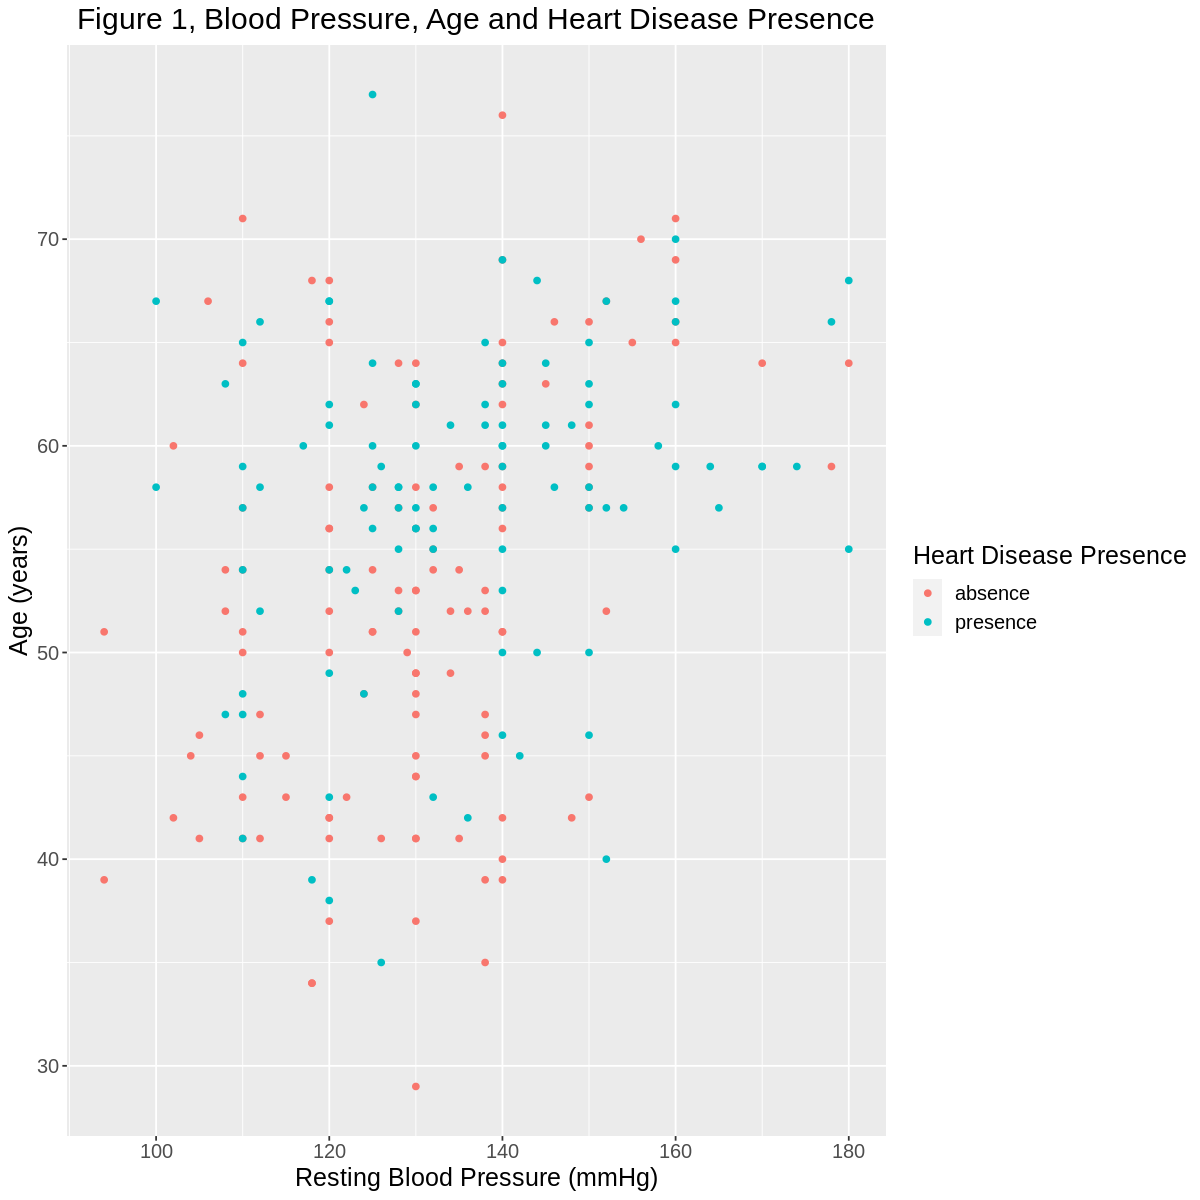

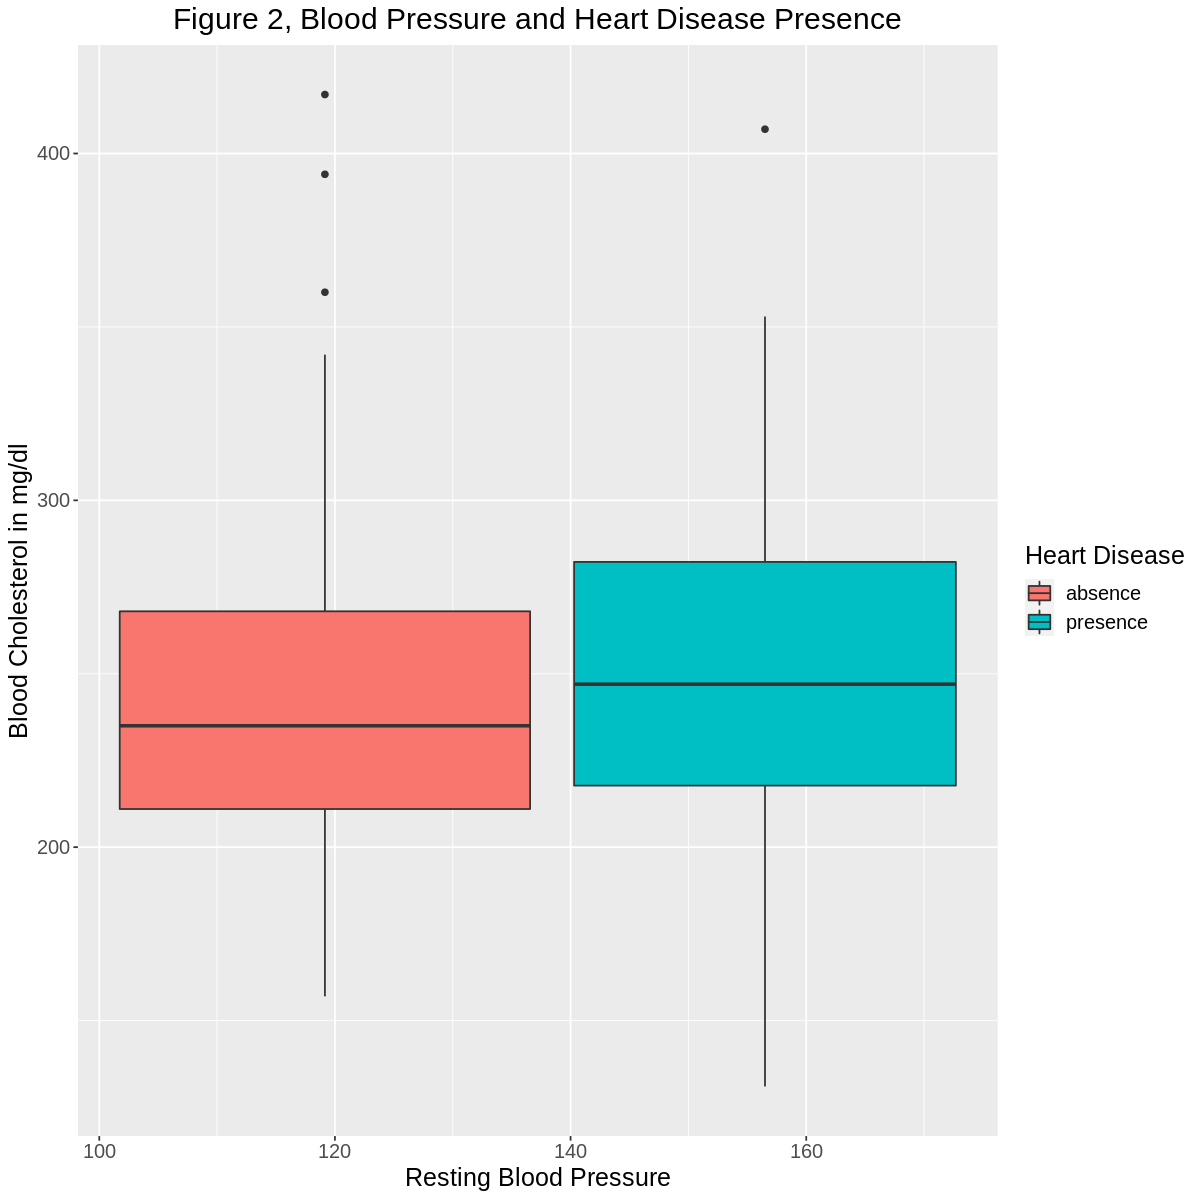

In [236]:
# plotting for data analysis
options(repr.plot.width = 10, repr.plot.height = 10) 

cholesterol_plot <- heart_train |> ggplot(aes(x= rbp, y= age, color = disease)) + geom_point() + 
            labs(x= "Resting Blood Pressure (mmHg)", y="Age (years)", color = "Heart Disease Presence") +
            ggtitle("Figure 1, Blood Pressure, Age and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
cholesterol_plot

options(repr.plot.width = 10, repr.plot.height = 10) 

blood_sugar_plot <- heart_train |> ggplot(aes(x= rbp, y = cholesterol, fill = disease)) + geom_boxplot() + 
            labs(x= "Resting Blood Pressure", y="Blood Cholesterol in mg/dl", fill ="Heart Disease") +
            ggtitle("Figure 2, Blood Pressure and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
blood_sugar_plot

### Visualization

The first plot is a scatter chart that shows the resting blood pressure plotted against age. We see that clearly, as age increases, blood pressure seems to increase. But more importantly, we will notice that we do not see a clear grouping of heart disease presence for high blood pressure or old patients. The presence of heart disease is scattered, and there is not much correlation between age and blood pressure with heart disease.

The second plot is a boxplot showing the distribution of cholesterol for patients with or without blood sugar levels over 120 mg/dl. It is grouped with the heart disease presence or absence, and it shows that people with higher blood sugar had more cholesterol, and people with heart disease also had higher medians of cholesterol.

## Performing the Data Analysis

First, we will figure the best k value to use to have maximum accuracy using the vfold function. We first scale and set up the recipe for the classifier, using our predictors. We will set neighbors as tune() as we will perform cross validation and see acuracies for many k values.

In [237]:
heart_recipe <- recipe(disease ~ age + rbp + cholesterol, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

We will now conduct cross validation with 5 folds and do so for k values 1 to 50, We would asses the accuracy of each k value cross validation by the collect metrics function.

In [238]:
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

Now, we may plot our results, showing the neighbors and their corresponding accuracy, represented as the mean..

In [239]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |> select(neighbors, mean)

accuracies

neighbors,mean
<dbl>,<dbl>
1,0.5509267
2,0.5509267
3,0.5292885
⋮,⋮
48,0.5693983
49,0.5648529
50,0.5648529


*Table 2, result of cross validation and tuning*

Visualizing our results, we may see what k values induce the greatest accuracy.

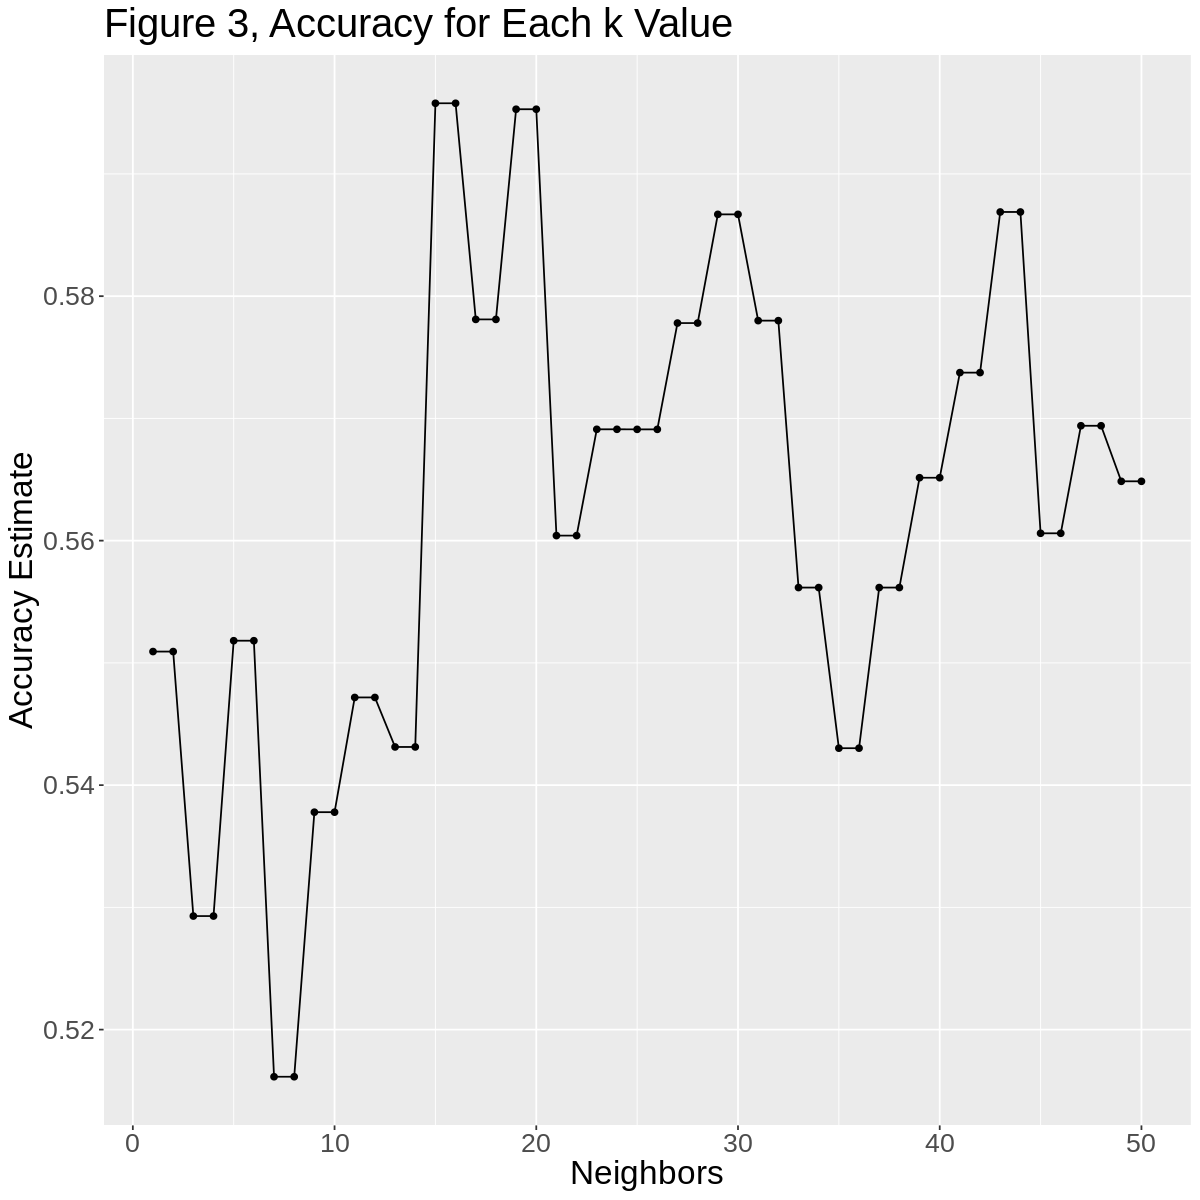

In [240]:
accuracy_vs_k <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 3, Accuracy for Each k Value")
accuracy_vs_k

In [241]:
max_accuracy_k <- accuracies |> arrange(desc(mean)) |> select (neighbors)|> head(1) |> pull()
max_accuracy_k

[1] 15

Hence, we would be using a k value of 15 to use in our KNN classification. Using our test data, we may assess the RMSPE of our model, which may show us our results of our predictor.

In [242]:
knn_spec_15 <- nearest_neighbor(weight_func = "rectangular", neighbors = max_accuracy_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_15 <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec_15) |>
    fit(data = heart_train)

heart_test_prediction <- predict(knn_fit_15, heart_test) |>
    bind_cols(heart_test)

heart_test_prediction 

heart_test_prediction |> 
            metrics(truth = disease, estimate = .pred_class) |> 
            filter(.metric == "accuracy")

.pred_class,age,rbp,cholesterol,disease
<fct>,<dbl>,<dbl>,<dbl>,<fct>
presence,56,120,236,absence
presence,62,140,268,presence
absence,57,120,354,absence
⋮,⋮,⋮,⋮,⋮
absence,45,110,264,presence
presence,57,130,236,presence
absence,38,138,175,absence


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368


We see that our accuracy is approximately 65%, which is a poor result as an predictor for heart disease. Patients would want to know if they have heart disease as a higher accuracy. This is likely due to our predictors not being clearly grouped well: we see that when we have plotted in our data anlaysis that age and blood pressure did not have clear groups to differientiate when heart disease is presence or absent. We may observe the majority classifier and compare our results.

Now, we will also see the confusion matrix of our model that was tested using the testing set. We will be able to see how may incorrect predictions we had and correct predictions we had. We will visualizse this as a bar graph.

In [243]:
confusion <- heart_test_prediction |> 
            conf_mat(truth = disease, estimate = .pred_class)
confusion

          Truth
Prediction absence presence
  absence       30       16
  presence      11       19

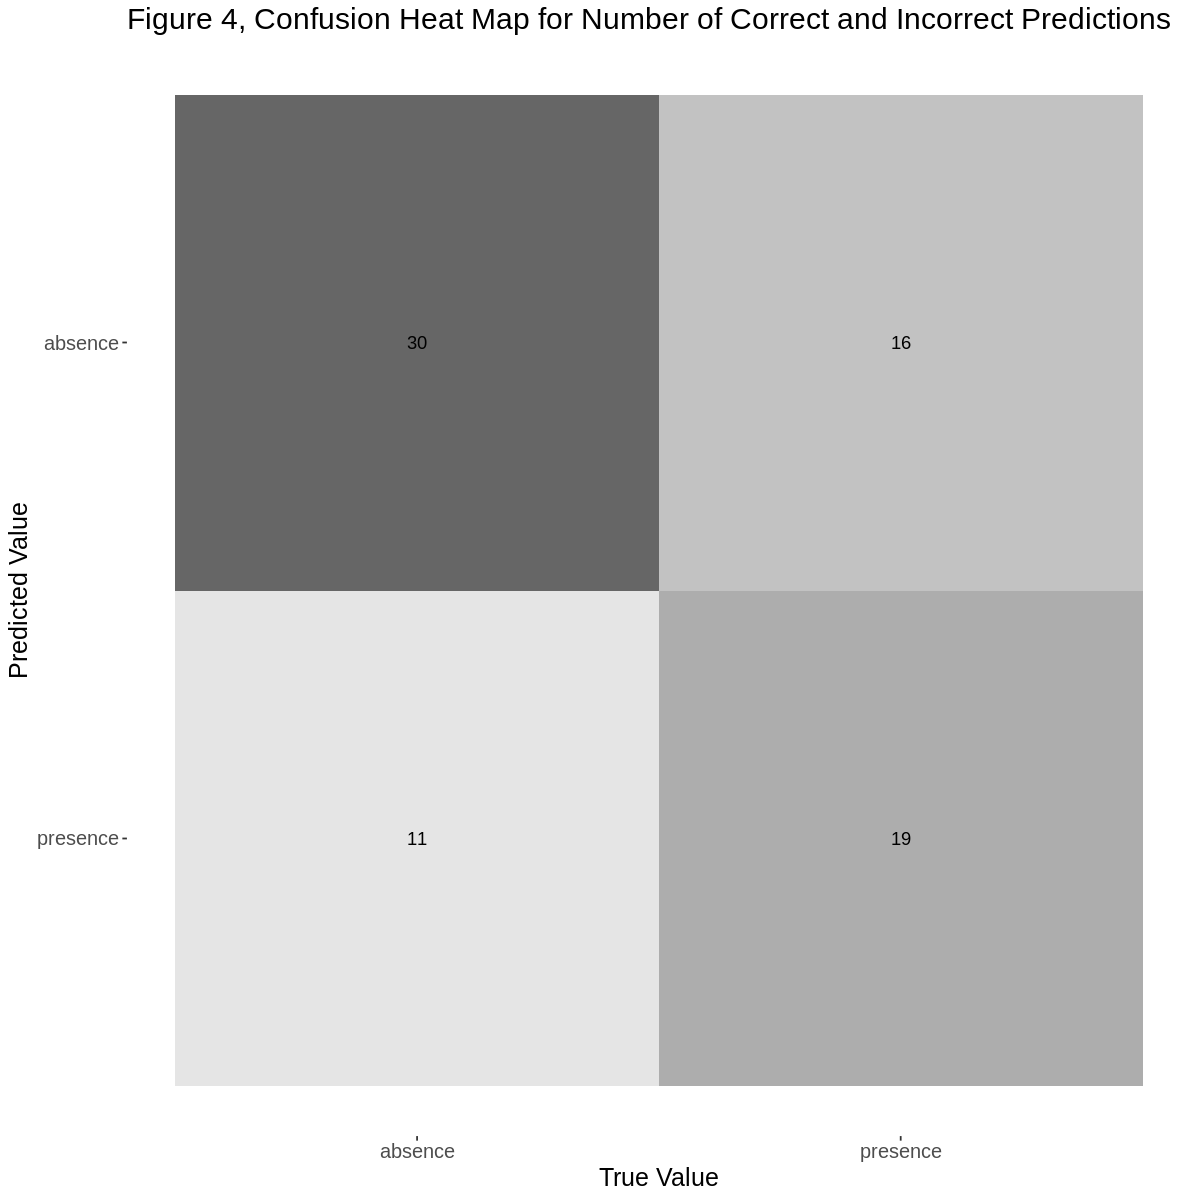

In [244]:
autoplot(confusion, type = "heatmap")+ xlab("True Value")+ ylab( "Predicted Value") +
theme(text = element_text(size = 15)) +
ggtitle("Figure 4, Confusion Heat Map for Number of Correct and Incorrect Predictions") 

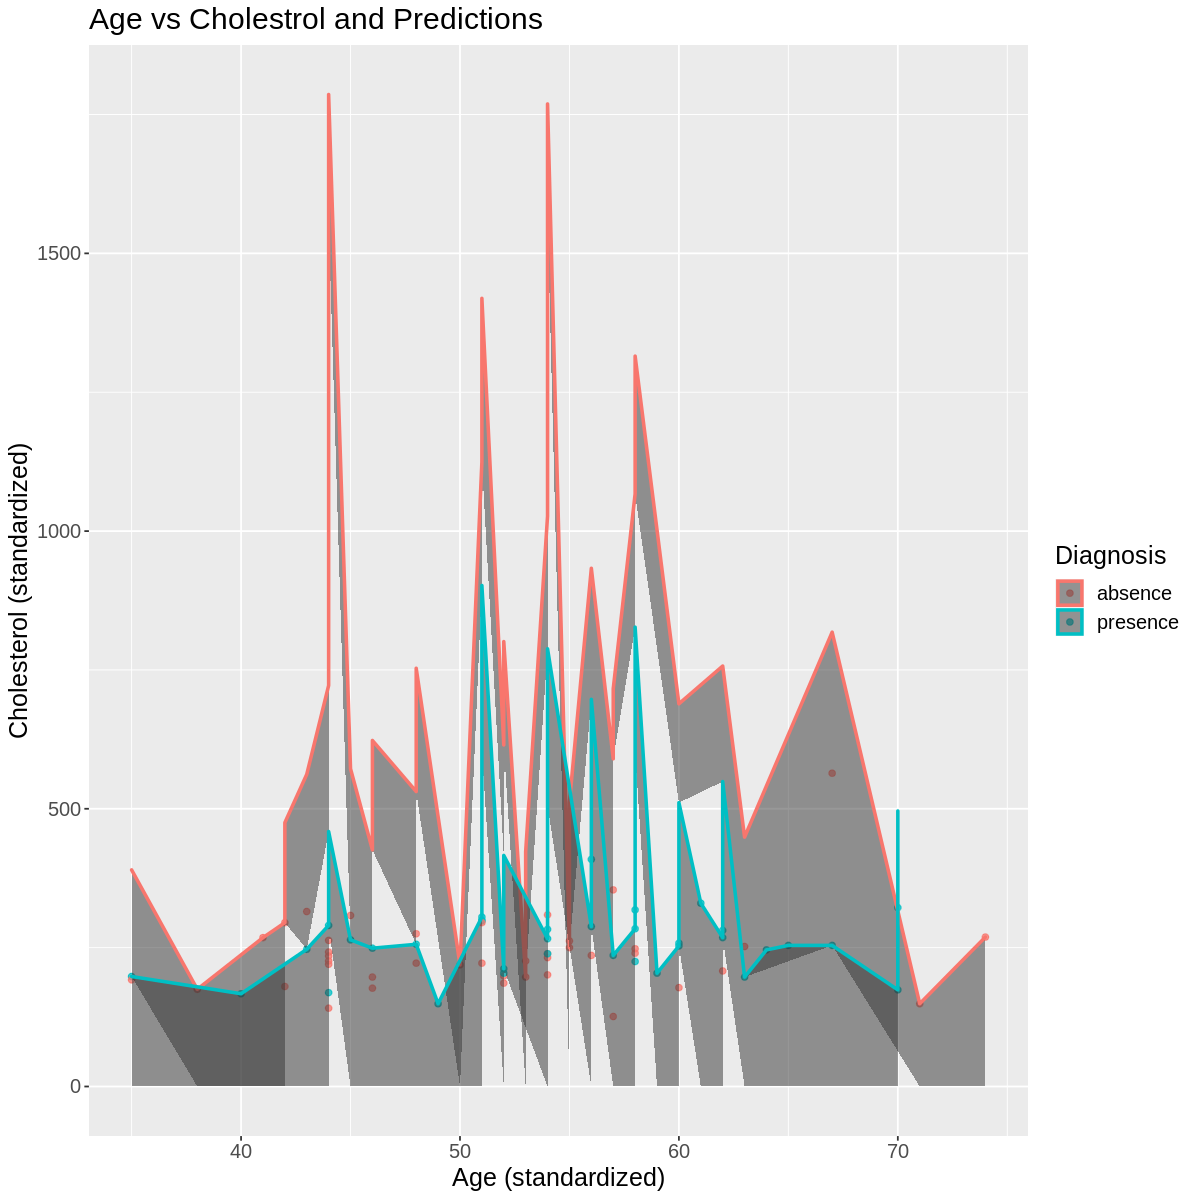

In [253]:
# create the grid of area/smoothness vals, and arrange in a data frame
# are_grid <- seq(min(heart_test$age), 
#                 max(heart_test$age), 
#                 length.out = 100)
# smo_grid <- seq(min(heart_test$cholesterol), 
#                 max(heart_test$cholesterol), 
#                 length.out = 100)
# asgrid <- as_tibble(expand.grid(age = are_grid, 
#                                 cholesterol = smo_grid))

# # use the fit workflow to make predictions at the grid points
# knnPredGrid <- predict(knn_fit_15, asgrid)

# # bind the predictions as a new column with the grid points
# prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
#   rename(Class = .pred_class)

heart_test_select <- select(heart_test_prediction, age, disease, cholesterol)
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_test, 
             mapping = aes(x = age, 
                           y = cholesterol, 
                           color = disease), 
             alpha = 0.75) +
  geom_area(data = heart_test_select, 
             mapping = aes(x = age, 
                           y = cholesterol, 
                           color = disease), 
             alpha = 0.5, 
             size = 1) +
  labs(color = "Diagnosis", 
       x = "Age (standardized)", 
       y = "Cholesterol (standardized)")  +
  theme(text = element_text(size = 15)) +
    ggtitle("Age vs Cholestrol and Predictions")

wkflw_plot

We see that there were 30 correct predictions of the absence of heart disease, and 11 incorrect predictions. There were 19 correct predictions of presence and 16 predictions of absence. This shows that we are less acurrate in predicting that a patient has heart disease than having it. 

## Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

Reasoning:
- Your predictive question is good, just remove the part that says "regression". You don't need to specify that you'll use classification in the question, but if you do, please say that it's KNN classification.
- Honestly, I would not recommend using FBS as a predictor unless you are absolutely certain that it is strongly correlated to the presence of heart disease. Looking at your first graph, I would say that any correlation present is small enough that FBS should be disregarded. Binary variables can hugely influence a classification algorithm because of their "all or nothing" nature, and I think including FBS will likely harm your model's accuracy rather than help it. As well, if you decide to use FBS in the model, you'll need to mutate it back to 0/1. Non-numerical predictors cannot be used in KNN classification because it calculates distance, which is a numerical value. 
- How will you show the KNN function on your final graphs? Unclear as to what you mean.
- Your methods are sparse, and you spend a lot of the word count describing your figures, which is unnecessary. For the final project, make sure that any commentary on the figures is truly commentary and not just description.

General Feedback:
- Your future questions should be about the data or the applications of the model, not the model itself.
- Your visualizations are great!! Unique and very descriptive. I'd like to see at least one general scatterplot in the final project but please keep doing interesting things.
- You don't need to read in dplyr as it's part of tidyverse.
- You spend a lot of time talking about diabetes and the effect of blood sugar on heart disease, but the effect itself seems to be fairly small. This makes your project feel somewhat tangential, as you're discussing diabetes but your model is about heart disease. I would like to see equal attention given to each predictor and more words spent discussing the model itself.

The data analysis shows that as age and resting blood pressure increase, so does the proportion of heart disease in a population.  For example, a 50 year old with a resting blood pressure of 110 mmHg is significantly less likely to have heart disease than a 70 year old with 160mmHg resting blood pressure.  The amount of blood cholesterol is found to impact the likelihood of developing heart disease.  The higher the blood cholesterol, the more likely it is the individual has heart disease.  The results are not surprising.  The heart stops working as well as a person ages; and higher resting blood pressure is a measure of how fast the heart is pumping blood through the body, so it makes sense that higher blood pressure could lead to heart disease since the heart is working harder.  Higher blood cholesterol being correlated with the presence of heart disease is expected as well, since the heart has to work harder to pump blood through smaller arteries.  These findings could help prevent heart disease.  While you can't prevent getting older, you can live a healthy lifestyle to keep your resting blood pressure and blood cholesterol levels low.  In the future, possible research questions include specific and effective ways to lower resting blood pressure and blood cholesterol, or if certain people are genetically predisposed to higher levels of cholesterol and RBP, and therefore, predisposed to heart disease.

## References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

   Centers for Disease Control and Prevention. (2021, May 18). High blood pressure symptoms and causes. Centers for Disease Control and Prevention. Retrieved April 6, 2023, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina. 
   
   Centers for Disease Control and Prevention. (2022, June 20). Diabetes and your heart. Centers for Disease Control and 
Prevention. Retrieved April 6, 2023, from https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls. 

   Cleveland Clinic. (n.d.). High cholesterol: Causes, symptoms and how it affects the body. Cleveland Clinic. Retrieved April 6, 2023, from https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases 
   
   U.S. Department of Health and Human Services. (2018, June 1). Heart health and aging. National Institute on Aging. 
Retrieved April 6, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging   